<center><h1>Parkinson disease diagnostic using time series data</h1></center>
<center><h2>Classification using machine learning</h2></center>

# Importation of librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import bias_variance_decomp
import psutil
import GPUtil

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


# Import the data

In [2]:
df = pd.read_csv('preprocessed-data\preprocessed_data.csv')

df.head()

,ID,Study,Group,Subjnum,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,...,mean_swing_time_left,std_stride_left,std_swing_left,max_swing_left,min_swing_left,cv_stride_left,cv_swing_left,mean_swing_stride_ratio_left,log_left,mean_double_stance_time
0,GaPt03,Ga,PD,3,female,82,1.45,50.000000,3.0,20.0,...,0.543326,0.250426,0.124893,0.7299,0.0100,16.856355,22.986800,36.693073,-429.032245,0.935088
1,GaPt04,Ga,PD,4,male,68,1.71,72.524691,2.5,25.0,...,-0.859187,0.182767,0.161860,-0.7200,-1.8899,14.242531,-18.838775,-69.058996,96.502798,0.865798
2,GaPt05,Ga,PD,5,female,82,1.53,51.000000,2.5,24.0,...,-0.609242,0.108519,0.044731,-0.5400,-0.8200,10.185169,-7.342067,-61.899132,41.773520,0.606564
3,GaPt06,Ga,PD,6,male,72,1.70,82.000000,2.0,16.0,...,0.413048,0.051538,0.019363,0.4600,0.3000,4.494682,4.687939,36.047953,-42.744401,0.154679
4,GaPt07,Ga,PD,7,female,53,1.67,54.000000,3.0,44.0,...,0.535093,0.535390,0.079130,0.7000,0.1800,36.544871,14.788033,38.060962,-135.812348,0.592562


In [3]:
# read .npy files
X = np.load('preprocessed-data\X.npy')
y = np.load('preprocessed-data\y.npy')

# Get the features and labels and encode them

In [59]:
# Separate the features and the label
X = df.drop(['ID', 'Study', 'Subjnum', 'Group', 'HoehnYahr'], axis=1)
y = df['Group']

# Convert the categorical label to numbers
y = y.astype('category')
y = y.cat.codes

# Convert "Gender" in X to numbers
X['Gender'] = X['Gender'].replace({'female': 0, 'male': 1})

# normalize the data
scaler = MinMaxScaler()
X[X.columns[:]] = scaler.fit_transform(X[X.columns[:]])

X.head()

,Gender,Age,Height (meters),Weight (kg),UPDRS,UPDRSM,TUAG,Speed_01 (m/sec),Speed_10,mean_stride_time_right,...,mean_swing_time_left,std_stride_left,std_swing_left,max_swing_left,min_swing_left,cv_stride_left,cv_swing_left,mean_swing_stride_ratio_left,log_left,mean_double_stance_time
0,0.0,0.92,0.000000,0.051724,0.285714,0.227273,1.000000,0.646212,0.421779,0.771538,...,0.987532,0.420505,0.450450,0.749988,0.867420,0.319581,0.971977,0.988728,0.060274,0.113510
1,1.0,0.64,0.001417,0.440081,0.357143,0.181818,0.158419,0.238579,0.452454,0.556148,...,0.186538,0.294175,0.596647,0.078707,0.342542,0.262351,0.388799,0.905067,0.632267,0.104723
2,0.0,0.92,0.000436,0.068966,0.342857,0.113636,0.274660,0.463621,0.296012,0.273847,...,0.329285,0.155544,0.133424,0.162045,0.638119,0.173516,0.549098,0.910731,0.572700,0.071850
3,1.0,0.72,0.001362,0.603448,0.228571,0.295455,0.140817,0.412860,0.543712,0.364814,...,0.913128,0.049153,0.033101,0.625029,0.947537,0.048924,0.716834,0.988218,0.480711,0.014548
4,0.0,0.34,0.001199,0.120690,0.628571,0.500000,0.402192,0.268190,0.269172,0.791183,...,0.982830,0.952574,0.269464,0.736145,0.914385,0.750658,0.857660,0.989811,0.379415,0.070075


In [60]:
y.head()

0    1
1    1
2    1
3    1
4    1
dtype: int8

# Classification with KNN

## Hyperparameters finetuning

### create the objective function

In [4]:
def my_KNN(k1, k2):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a KNN classifier
    clf = KNeighborsClassifier(n_neighbors=int(k2))

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [5]:
pbounds = {
    'k1': (5, 30),
    'k2': (5, 10)
    }


optimizer = BayesianOptimization(
    f=my_KNN,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    k2     |
-------------------------------------------------
| 1         | 0.9609    | 15.43     | 8.602     |
| 2         | 0.9617    | 5.003     | 6.512     |
| 3         | 0.9613    | 8.669     | 5.462     |
| 4         | 0.9617    | 9.657     | 6.728     |
| 5         | 0.9606    | 14.92     | 7.694     |
| 6         | 0.9609    | 15.48     | 8.426     |
| 7         | 0.9592    | 10.11     | 9.391     |
| 8         | 0.9609    | 5.685     | 8.352     |
| 9         | 0.9606    | 15.43     | 7.793     |
| 10        | 0.9613    | 8.51      | 5.991     |
| 11        | 0.9613    | 10.97     | 5.473     |
| 12        | 0.9613    | 5.0       | 5.0       |
| 13        | 0.9592    | 20.02     | 9.974     |
| 14        | 0.9613    | 30.0      | 5.0       |
| 15        | 0.9606    | 29.99     | 7.904     |
| 16        | 0.9613    | 27.18     | 5.0       |
| 17        | 0.9613    | 24.32     | 5.0       |
| 18        | 0.9606    | 25.6      | 7.419     |


## Perform Binary classification

In [8]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=int(optimizer.max['params']['k1']))
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a KNN classifier
clf = KNeighborsClassifier(n_neighbors=int(optimizer.max['params']['k2']))

# Get GPU usage before running your code
start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()
# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
end_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve multi-class classification
y_prob = clf.predict_proba(X_test).argmax(axis=1)
macro_roc_auc_ovo = roc_auc_score(y_test.to_numpy(), y_prob, multi_class="ovo", average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(clf,X_train, y_train.to_numpy(), X_test, y_test.to_numpy(),loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print("Bias:", bias)
print("Variance:", var)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Loss: 0.04268767745599091
Accuracy: 0.9617262918796139
Precision: 0.9616942683415588
Recall: 0.9617262918796139
F1 Score: 0.9617091236351043
TP: 8468
TN: 8468
FP: 337
FN: 337
AUC: 0.9549937217472619
Bias: 0.03827370812038614
Variance: 0.019908574673480974
CPU Usage: 46.5%
Memory Usage: 0.0%
GPU Usage: 0.0%
Execution Time: 0.34337449073791504 seconds


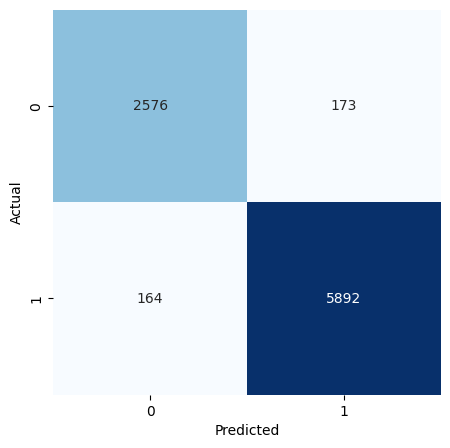

In [9]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

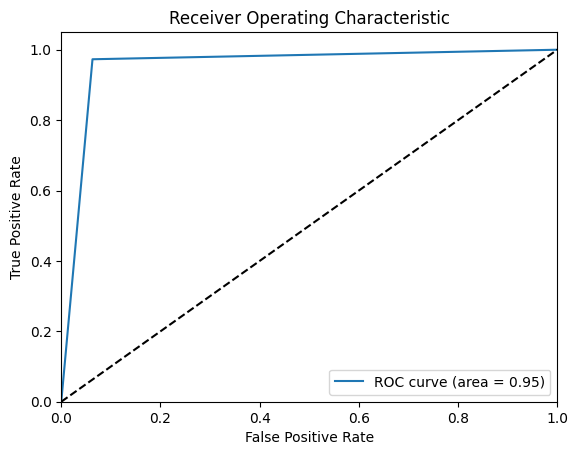

In [10]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Classification with Naive Bayes

## Hyperparameters finetuning

### create the objective function

In [69]:
def my_naivebayes(k1):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a Naive Bayes classifier
    clf = GaussianNB()

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [73]:
pbounds = {
    'k1': (5, 30)
    }

optimizer = BayesianOptimization(
    f=my_naivebayes,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |
-------------------------------------
| 1         | 0.7576    | 15.43     |
| 2         | 0.8459    | 23.01     |
| 3         | 0.8165    | 5.003     |
| 4         | 0.7576    | 12.56     |
| 5         | 0.8788    | 8.669     |
| 6         | 0.8788    | 7.308     |
| 7         | 0.8788    | 9.657     |
| 8         | 0.7576    | 13.64     |
| 9         | 0.8185    | 14.92     |
| 10        | 0.8459    | 18.47     |
| 11        | 0.8788    | 7.966     |
| 12        | 0.8788    | 10.61     |
| 13        | 0.8133    | 20.35     |
| 14        | 0.8459    | 24.69     |
| 15        | 0.8459    | 26.42     |
| 16        | 0.8182    | 28.14     |
| 17        | 0.8165    | 6.418     |
| 18        | 0.8182    | 30.0      |
| 19        | 0.8459    | 21.89     |
| 20        | 0.8459    | 17.44     |
Bayes optimization takes 0.40 seconds to tune
{'target': 0.8787878787878788, 'params': {'k1': 8.668897270427827}}


## Perform Binary classification

In [110]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=8)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get GPU usage before running your code
start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

# Create a Naive Bayes classifier
clf = GaussianNB()

start_time = time.time()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
end_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve multi-class classification
y_prob = clf.predict_proba(X_test).argmax(axis=1)
macro_roc_auc_ovo = roc_auc_score(y_test.to_numpy(), y_prob, multi_class="ovo", average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(clf,X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print("Bias:", bias)
print("Variance:", var)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Loss: 0.2534848484848484
Accuracy: 0.7878787878787878
Precision: 0.7877648667122351
Recall: 0.7878787878787878
F1 Score: 0.7870880284673388
TP: 26
TN: 26
FP: 7
FN: 7
AUC: 0.7833333333333334
Bias: 0.15151515151515152
Variance: 0.16015151515151516
CPU Usage: -4.6%
Memory Usage: 0.0%
GPU Usage: 0.0%
Execution Time: 0.0157928466796875 seconds


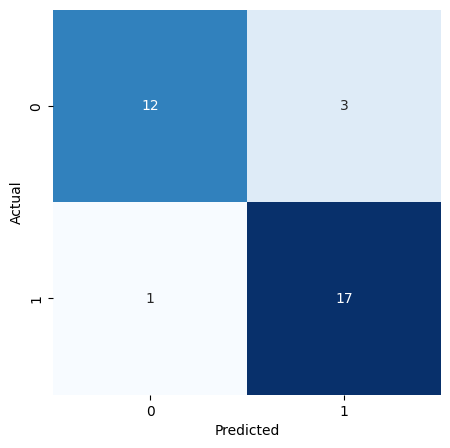

In [81]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

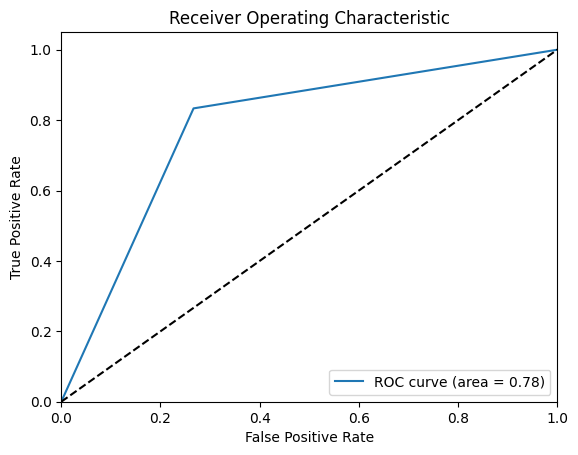

In [82]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification with Decision trees

## Hyperparameters finetuning

### create the objective function

In [84]:
def my_decisiontree(k1, md, msl, mss):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a Decision Tree classifier
    clf = DecisionTreeClassifier(max_depth=int(md), min_samples_leaf=int(msl), min_samples_split=int(mss))

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [85]:
pbounds = {
    'k1': (5, 30),
    'md': (1, 10),
    'msl': (1, 10),
    'mss': (2, 10)
    }

optimizer = BayesianOptimization(
    f=my_decisiontree,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    md     |    msl    |    mss    |
-------------------------------------------------------------------------
| 1         | 1.0       | 15.43     | 7.483     | 1.001     | 4.419     |
| 2         | 0.8783    | 8.669     | 1.831     | 2.676     | 4.764     |
| 3         | 1.0       | 14.92     | 5.849     | 4.773     | 7.482     |
| 4         | 1.0       | 10.11     | 8.903     | 1.246     | 7.364     |
| 5         | 0.9696    | 15.43     | 6.028     | 2.263     | 3.585     |
| 6         | 1.0       | 25.02     | 9.714     | 3.821     | 7.539     |
| 7         | 1.0       | 26.91     | 9.051     | 1.765     | 2.312     |
| 8         | 1.0       | 9.246     | 8.903     | 1.885     | 5.369     |
| 9         | 1.0       | 28.95     | 5.798     | 7.227     | 4.524     |
| 10        | 1.0       | 22.16     | 8.512     | 1.165     | 8.001     |
| 11        | 1.0       | 17.05     | 10.0      | 7.07      | 10.0      |
| 12        | 0.8783    | 22.34     | 

## Perform Binary classification

In [111]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Get GPU usage before running your code
start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()

# Create a Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=1, min_samples_split=4)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
end_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve multi-class classification
y_prob = clf.predict_proba(X_test).argmax(axis=1)
macro_roc_auc_ovo = roc_auc_score(y_test.to_numpy(), y_prob, multi_class="ovo", average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(clf,X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print("Bias:", bias)
print("Variance:", var)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Loss: 0.09318181818181817
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
TP: 33
TN: 33
FP: 0
FN: 0
AUC: 1.0
Bias: 0.0
Variance: 0.0931818181818182
CPU Usage: -4.6%
Memory Usage: 0.0%
GPU Usage: 0.0%
Execution Time: 0.0 seconds


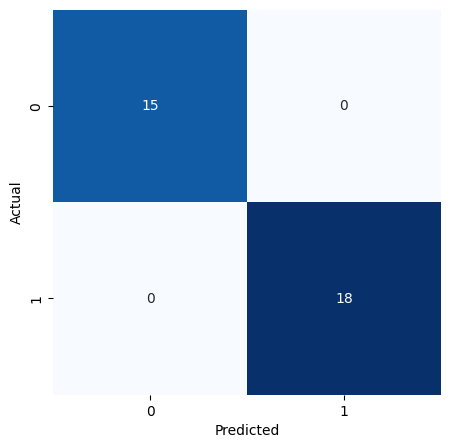

In [89]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

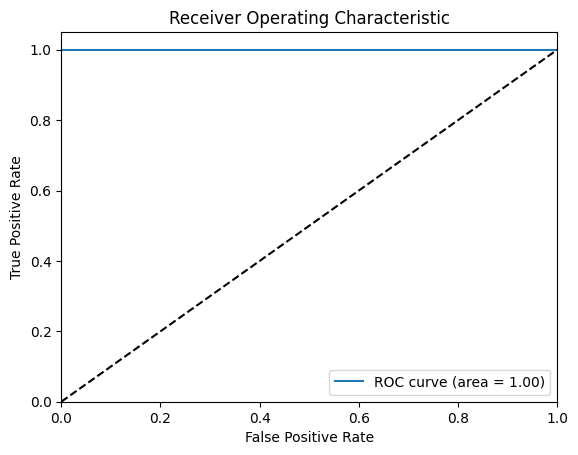

In [90]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification with Random Forest

## Hyperparameters finetuning

### create the objective function

In [91]:
def my_randomforest(k1, md, msl, mss, n):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a Random Forest classifier
    clf = RandomForestClassifier(max_depth=int(md), min_samples_leaf=int(msl), min_samples_split=int(mss), n_estimators=int(n))

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [92]:
pbounds = {
    'k1': (5, 30),
    'md': (1, 10),
    'msl': (1, 10),
    'mss': (2, 10),
    'n': (10, 100)
    }

optimizer = BayesianOptimization(
    f=my_randomforest,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    md     |    msl    |    mss    |     n     |
-------------------------------------------------------------------------------------
| 1         | 0.9388    | 15.43     | 7.483     | 1.001     | 4.419     | 23.21     |
| 2         | 0.8776    | 7.308     | 2.676     | 4.11      | 5.174     | 58.49     |
| 3         | 0.9696    | 15.48     | 7.167     | 2.84      | 9.025     | 12.46     |
| 4         | 0.9388    | 21.76     | 4.756     | 6.028     | 3.123     | 27.83     |
| 5         | 0.8755    | 25.02     | 9.714     | 3.821     | 7.539     | 88.88     |
| 6         | 0.8426    | 27.37     | 1.765     | 1.351     | 3.359     | 89.03     |
| 7         | 0.9075    | 7.459     | 4.79      | 9.621     | 6.265     | 72.27     |
| 8         | 0.8755    | 12.89     | 7.179     | 8.512     | 2.146     | 77.51     |
| 9         | 0.9696    | 29.72     | 7.733     | 3.524     | 8.314     | 19.29     |
| 10        | 0.9696    | 16.2      | 9.177     | 3.64

## Perform Binary classification

In [112]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=12)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Get GPU usage before running your code
start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

# Create a Random Forest classifier
clf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=11)

start_time = time.time()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
end_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve multi-class classification
y_prob = clf.predict_proba(X_test).argmax(axis=1)
macro_roc_auc_ovo = roc_auc_score(y_test.to_numpy(), y_prob, multi_class="ovo", average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(clf,X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print("Bias:", bias)
print("Variance:", var)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Loss: 0.07666666666666666
Accuracy: 0.9696969696969697
Precision: 0.9712918660287082
Recall: 0.9696969696969697
F1 Score: 0.9695840040667628
TP: 32
TN: 32
FP: 1
FN: 1
AUC: 0.9666666666666667
Bias: 0.030303030303030304
Variance: 0.06333333333333332
CPU Usage: -2.0%
Memory Usage: 0.0%
GPU Usage: 0.0%
Execution Time: 0.0016255378723144531 seconds


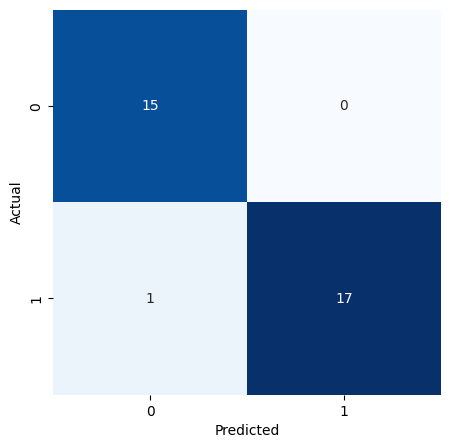

In [95]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

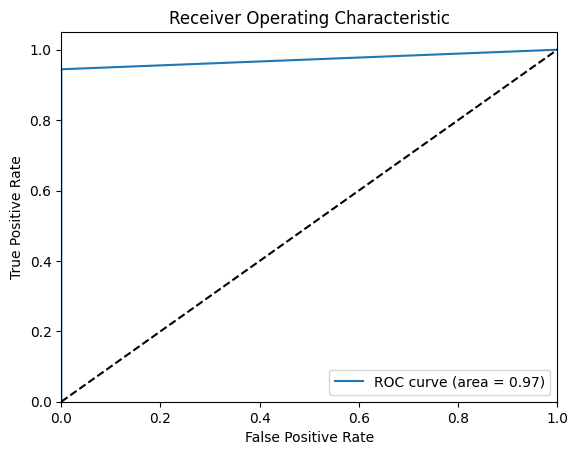

In [96]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification with SVM

## Hyperparameters finetuning

### create the objective function

In [97]:
def my_svm(k1, c, gamma):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a SVM classifier
    clf = SVC(C=c, gamma=gamma)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [98]:
pbounds = {
    'k1': (5, 30),
    'c': (1, 10),
    'gamma': (1, 10)
    }

optimizer = BayesianOptimization(
    f=my_svm,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=20, n_iter=20)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |     c     |   gamma   |    k1     |
-------------------------------------------------------------
| 1         | 0.8165    | 4.753     | 7.483     | 5.003     |
| 2         | 0.8165    | 3.721     | 2.321     | 7.308     |
| 3         | 0.9075    | 2.676     | 4.11      | 14.92     |
| 4         | 0.9075    | 5.849     | 4.773     | 22.13     |
| 5         | 0.8165    | 2.84      | 8.903     | 5.685     |
| 6         | 0.9088    | 7.034     | 4.756     | 18.97     |
| 7         | 0.9075    | 2.263     | 2.783     | 25.02     |
| 8         | 0.8479    | 9.714     | 3.821     | 22.31     |
| 9         | 0.8133    | 8.888     | 9.051     | 7.126     |
| 10        | 0.9088    | 1.351     | 2.528     | 26.95     |
| 11        | 0.7871    | 1.885     | 4.79      | 28.95     |
| 12        | 0.9088    | 5.798     | 7.227     | 12.89     |
| 13        | 0.8165    | 7.179     | 8.512     | 5.457     |
| 14        | 0.8084    | 7.751     | 9.9       | 23.7      |
| 15    

## Perform Binary classification

In [113]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=26)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Get GPU usage before running your code
start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()

# Create a SVM classifier
clf = SVC(C=5.234, gamma=1)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
end_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve multi-class classification
y_prob = clf.decision_function(X_test)
macro_roc_auc_ovo = roc_auc_score(y_test.to_numpy(), y_prob, multi_class="ovo", average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(clf,X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print("Bias:", bias)
print("Variance:", var)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Loss: 0.10666666666666666
Accuracy: 0.9696969696969697
Precision: 0.9712918660287082
Recall: 0.9696969696969697
F1 Score: 0.9695840040667628
TP: 32
TN: 32
FP: 1
FN: 1
AUC: 0.9851851851851852
Bias: 0.06060606060606061
Variance: 0.09121212121212123
CPU Usage: -4.5%
Memory Usage: -0.10000000000000853%
GPU Usage: 0.0%
Execution Time: 0.0 seconds


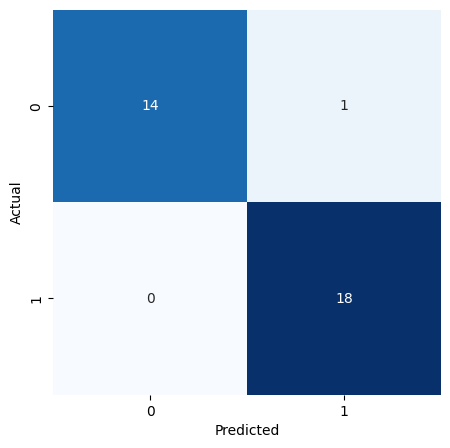

In [102]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

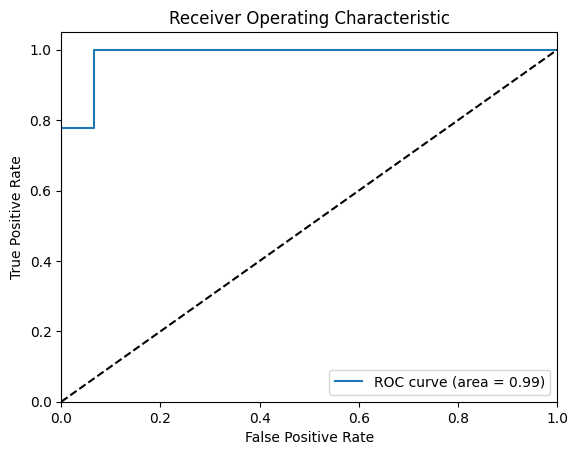

In [103]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()